# Load Data Set

In [20]:
from datasets import load_dataset
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

dataset = load_dataset("go_emotions")

train_dataset_raw = dataset["train"]
val_dataset_raw = dataset["validation"]
test_dataset_raw = dataset["test"]

print(f"Train size: {len(train_dataset_raw)}")
print(f"Validation size: {len(val_dataset_raw)}")
print(f"Test size: {len(test_dataset_raw)}")

Using device: mps
Train size: 43410
Validation size: 5426
Test size: 5427


Label Pereparation

In [21]:
print(train_dataset_raw.column_names)
print(train_dataset_raw[1])

['text', 'labels', 'id']
{'text': 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead', 'labels': [27], 'id': 'ed00q6i'}


In [22]:
import numpy as np
import torch
from torch.nn import BCEWithLogitsLoss
from collections import Counter

num_labels = 27  # GoEmotions has 28 emotion classes (excluding 'neutral')

def encode_labels(example):
    # Exclude neutral (label 27)
    labels = np.zeros(num_labels)
    for label in example['labels']:
        if label < num_labels:  # Only 0 to 26
            labels[label] = 1
    example['labels'] = labels.tolist()
    return example

train_dataset = train_dataset_raw.shuffle(seed=42).map(encode_labels)
val_dataset = val_dataset_raw.map(encode_labels)
test_dataset = test_dataset_raw.map(encode_labels)


print("Head of train dataset:")
print(train_dataset[1])
print("\nHead of validation dataset:")
print(val_dataset[0])
print("\nHead of test dataset:")
print(test_dataset[0])


print("\nNumber of labels in train dataset:", len(train_dataset[0]['labels']))



all_labels = [tuple(labels) for labels in train_dataset["labels"]]
flat_counts = np.sum(train_dataset["labels"], axis=0)
print("Label counts per class:", flat_counts)


# train_dataset = train_dataset.select(range(5000))
# val_dataset = val_dataset.select(range(500))


empty_count = 0
non_empty_count = 0
for sample in train_dataset:
    if sum(sample['labels']) == 0:
        empty_count += 1
    else:
        non_empty_count += 1

print(f"\n\nEmpty label samples: {empty_count}")
print(f"Non-empty label samples: {non_empty_count}")

Head of train dataset:
{'text': 'Done, good luck with your thing.', 'labels': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'id': 'ef6ysvb'}

Head of validation dataset:
{'text': 'Is this in New Orleans?? I really feel like this is New Orleans.', 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'id': 'edgurhb'}

Head of test dataset:
{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!', 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'id': 'eecwqtt'}

Number of labels in train dataset: 27
Label counts per class: [4130 2328 1567 2470 2939 1087 1368 2191  641 1269 2022  793  303  853
  596 2662   77 1452 2086  164 1581  111 1110  153  545 1326 1060]


Empty label samples: 12823
Non-empty label samples: 30587


In [23]:
# Filter Neutral Samples as empty samples add noise and teach the model that predicting nothing is normal
# Filter training samples that have at least one label
train_dataset = train_dataset.filter(lambda x: sum(x['labels']) > 0)
val_dataset = val_dataset.filter(lambda x: sum(x['labels']) > 0)

print(f"Filtered train size: {len(train_dataset)}")
print(f"Filtered validation size: {len(val_dataset)}")

Filtered train size: 30587
Filtered validation size: 3834


In [24]:
label_counts = [sum(example['labels']) for example in train_dataset]
print("Average labels/sample:", np.mean(label_counts))
print("Unique label values:", np.unique(train_dataset[0]['labels']))


labels_array = np.array([x['labels'] for x in train_dataset])
print("\n\nUnique label vectors in training set:", np.unique(labels_array, axis=0).shape[0])
for i in range(5):
    print(f"Train sample {i}: {train_dataset[i]['text']}")
    print(f"Val sample {i}:   {val_dataset[i]['text']}")

Average labels/sample: 1.2058717755909374
Unique label values: [0 1]


Unique label vectors in training set: 642
Train sample 0: I would say they do because it was a horrible accident but they were also in the wrong. The military tried to get them to disperse they didnt.
Val sample 0:   You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!
Train sample 1: Done, good luck with your thing.
Val sample 1:   I've never been this sad in my life!
Train sample 2: Eat better.
Val sample 2:   The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today
Train sample 3: So you stay on your theft from auto waiting for them to dispatch the next shift to the backlog of calls.
Val sample 3:   He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.
Train sample 4: Glad to hear it's ubiquitous and not an OS thing

#Tokenize the Text with DistilBertTokenizer Fast

In [25]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset_tk = train_dataset.map(tokenize, batched=True)
val_dataset_tk = val_dataset.map(tokenize, batched=True)
test_dataset_tk = test_dataset.map(tokenize, batched=True)

# This ensures your dataset is ready for PyTorch training
train_dataset_tk.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset_tk.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset_tk.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("Head of tokenized train dataset:")
print(train_dataset_tk[1])


Map:   0%|          | 0/3834 [00:00<?, ? examples/s]

Head of tokenized train dataset:
{'labels': tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]), 'input_ids': tensor([ 101, 2589, 1010, 2204, 6735, 2007, 2115, 2518, 1012,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 

In [26]:
from transformers import Trainer
from sklearn.metrics import f1_score, accuracy_score

labels_matrix = np.array(train_dataset["labels"])
label_freq = labels_matrix.sum(axis=0)
num_samples = labels_matrix.shape[0]

# Avoid divide-by-zero and clip very large weights
pos_weights = (num_samples - label_freq) / (label_freq + 1e-5)
pos_weights = np.clip(pos_weights, a_min=1.0, a_max=None)

class_weights_tensor = torch.tensor(pos_weights, dtype=torch.float).to(device)


class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss


def compute_metrics(pred):
    preds = pred.predictions
    labels = pred.label_ids

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(preds)
    optimal_threshold = 0.7  # You can try different values later

    y_pred = np.where(probs >= optimal_threshold, 1, 0)

    print("Sample true:", labels[0])
    print("Sample pred:", y_pred[0])
    # print("Raw logits sample:", preds[0])
    # print("Sigmoid probs sample:", probs[0])
    
    f1 = f1_score(labels, y_pred, average='micro')
    acc = accuracy_score(labels, y_pred)

    return {"accuracy": acc, "f1": f1}

In [27]:
from transformers import DistilBertForSequenceClassification
from transformers import TrainerCallback

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification"
).to(device)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./lotuso",
    eval_strategy="epoch",   
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="cosine",
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)
class BestF1Callback(TrainerCallback):
    def __init__(self):
        self.best_f1 = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        f1 = metrics.get("eval_f1", 0)
        if f1 > self.best_f1:
            print(f"\n🌟 New best F1: {f1:.4f}")
            self.best_f1 = f1
            control.should_save = True
        else:
            control.should_save = False
        return control

In [29]:

trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tk,
    eval_dataset=val_dataset_tk,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.742500,0.733147,0.209703,0.478717
2,0.696600,0.596563,0.209442,0.503207
3,0.484100,0.619913,0.245696,0.541175
4,0.391500,0.661452,0.251435,0.549706
5,0.366500,0.699337,0.281429,0.561523
6,0.262200,0.791410,0.276734,0.561480
7,0.263600,0.853497,0.302556,0.571333
8,0.211100,0.910298,0.318466,0.578238
9,0.224200,0.925611,0.322118,0.579120
10,0.199000,0.947300,0.330725,0.582343


Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample pred: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample true: [0 0 0 0 1 0 0 0 0 0 

TrainOutput(global_step=9560, training_loss=0.40497009231705045, metrics={'train_runtime': 3016.203, 'train_samples_per_second': 101.409, 'train_steps_per_second': 3.17, 'total_flos': 1.013396691610368e+16, 'train_loss': 0.40497009231705045, 'epoch': 10.0})

In [47]:
# Print log history (optional)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

log_history = trainer.state.log_history
print("\nTraining log history:")
for log in log_history:
    if "eval_f1" in log:
        print(f"Epoch {log['epoch']:.2f} - F1: {log['eval_f1']:.4f}, Accuracy: {log['eval_accuracy']:.4f}")

# Save model and tokenizer
# trainer.save_model("./lotus_final_model")           # Also does model.save_pretrained()
# trainer.save_state()

label_list = [dataset['train'].features['labels'].feature.int2str(i) 
              for i in range(dataset['train'].features['labels'].feature.num_classes) 
              if dataset['train'].features['labels'].feature.int2str(i).lower() != 'neutral']

# Get label list from the dataset (index to string)
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

model.config.id2label = {str(k): v for k, v in id2label.items()}
model.config.label2id = label2id
model.config.num_labels = len(label_list)
model.config.problem_type = "multi_label_classification"

# Save model and tokenizer
model.save_pretrained("./lotus_final_model")
tokenizer.save_pretrained("./lotus_final_model")

# Also save Trainer state if you're using Trainer
trainer.save_model("./lotus_final_model")
trainer.save_state()




# Final evaluation on test set
metrics = trainer.evaluate(test_dataset_tk)
print("\nFinal Evaluation on Test Set:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



Training log history:
Epoch 1.00 - F1: 0.4787, Accuracy: 0.2097
Epoch 2.00 - F1: 0.5032, Accuracy: 0.2094
Epoch 3.00 - F1: 0.5412, Accuracy: 0.2457
Epoch 4.00 - F1: 0.5497, Accuracy: 0.2514
Epoch 5.00 - F1: 0.5615, Accuracy: 0.2814
Epoch 6.00 - F1: 0.5615, Accuracy: 0.2767
Epoch 7.00 - F1: 0.5713, Accuracy: 0.3026
Epoch 8.00 - F1: 0.5782, Accuracy: 0.3185
Epoch 9.00 - F1: 0.5791, Accuracy: 0.3221
Epoch 10.00 - F1: 0.5823, Accuracy: 0.3307
Epoch 10.00 - F1: 0.4660, Accuracy: 0.2278
Epoch 10.00 - F1: 0.4660, Accuracy: 0.2278
Sample true: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Sample pred: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]

Final Evaluation on Test Set:
eval_loss: 0.6756
eval_accuracy: 0.2278
eval_f1: 0.4660
eval_runtime: 13.5371
eval_samples_per_second: 400.8990
eval_steps_per_second: 6.2790
epoch: 10.0000


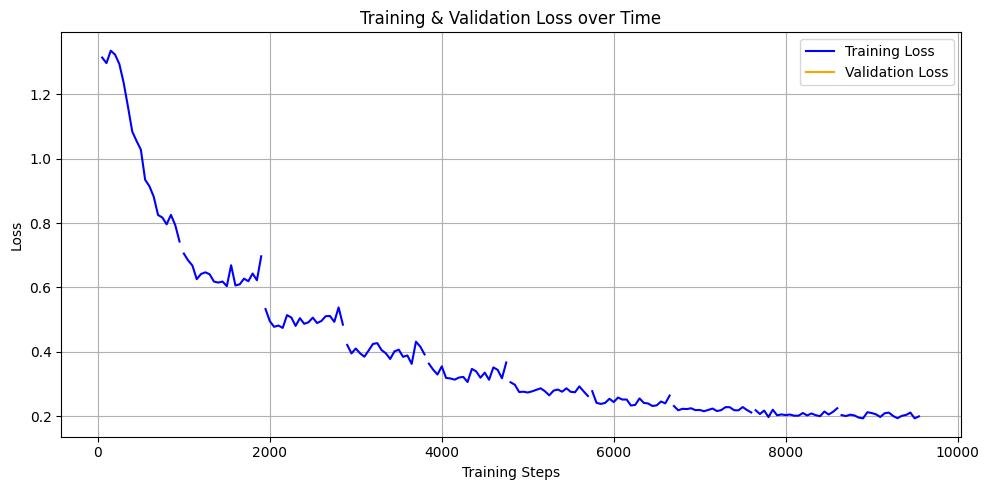

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
log_df = pd.DataFrame(log_history)


plt.figure(figsize=(10, 5))

# Training loss
if 'loss' in log_df.columns:
    plt.plot(log_df["step"], log_df["loss"], label="Training Loss", color='blue')

# Validation loss (logged during eval steps)
if "eval_loss" in log_df.columns:
    plt.plot(log_df["step"], log_df["eval_loss"], label="Validation Loss", color='orange')

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


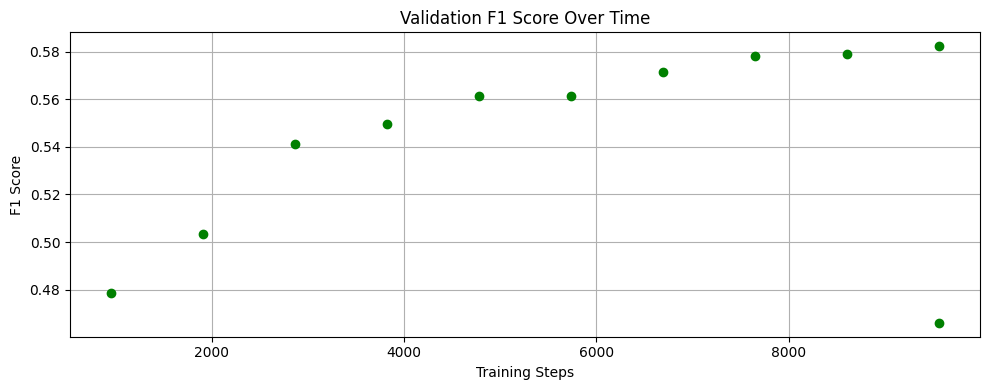

In [36]:
if "eval_f1" in log_df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(log_df["step"], log_df["eval_f1"], marker='o', color='green')
    plt.title("Validation F1 Score Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [44]:

# Sigmoid function for multi-label output
sigmoid = lambda x: 1 / (1 + np.exp(-x))

# Get label index mapping
id2label = dataset['train'].features['labels'].feature.int2str


def predict_emotions(text, threshold=0.5):
    # Tokenize and move input to correct device
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = sigmoid(logits.cpu().numpy()[0])  # move to CPU before numpy

    # Return all emotions with prob >= threshold
    return [(id2label(i), float(p)) for i, p in enumerate(probs) if p >= threshold]

# Example
#print(predict_emotions("I am scared and angry, but also a bit hopeful."))

print(predict_emotions("loved"))
print(predict_emotions("I am happy and sad at the same time."))


[('love', 0.9978526830673218)]
[('joy', 0.8134889006614685), ('sadness', 0.9712228178977966)]
